In [771]:
import matplotlib.pyplot as plt
import numpy as np
from exotic_ld import StellarLimbDarkening
from astropy.modeling.fitting import LevMarLSQFitter
import lmfit
from scipy import stats
from astropy.io import fits
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
import matplotlib.ticker as ticker
import batman 
import xarray as xr
import netCDF4
import h5netcdf
import json
from astropy.utils.misc import JsonCustomEncoder
import os
from cycler import cycler
import pandas as pd

In [ ]:
#get the wavelength ranges for bins
bins = pd.read_csv('TOI134_01_60pix_bins.txt', skiprows=1, sep=' ', names=['short', 'long', 'center', 'width'])

In [ ]:
# specify the file name, path, save path, and information about the target 
spec_file = 'wasp178b-nrs2.xc'
name=spec_file.split('.')[0]
lc_dir = './speclcs/'

if os.path.isdir('./outputs/'+name) is False:
    os.mkdir('./outputs/'+name)
save_dir = './outputs/'+name+'/'

grating = 'G395H' 
ld_model = 'mps1'
ld_type = 'nonlinear'
# ld_type = 'quadratic'

'''parameters for limb darkening calculations'''
Teff = 9360  
logg = 4.31 
M_H = 0.21 #metallicity

'''transit parameters'''  #using parameters consistent with MIRI results 
T0       = 60010.50916538359                    # BJD time of inferior conjunction
period   = 4.37808                     # orbital period (days) BJD_TDB
Rp       = 0.10731046635518635                            # planet radius (in units of stellar radii)
aRs      = 9.193064867066578                           # semi-major axis (input a/Rs so units of stellar radii) 
inc      = 86.61964115942803                            # orbital inclination
ecc      = 0.0                              # eccentricity
omega    = 0                             # longitude of periastron

rho_star = (3*np.pi)/(6.67259e-8*(period*86400)**2)*(aRs)**3     # stellar density (g/cm^3) from a/Rs

In [775]:
def get_wlc(filename):
    '''
    Read in white light curve 
    
    ======
    INPUT: 
    ======
    - filename for xarray file

    ======    
    OUTPUT: 
    ======
    - time (BJD_TDB), raw_flux, raw_flux_error, 
    shift_x, shift_y
    '''
    
    #read in xarray file
    ds = xr.open_dataset(lc_dir+filename, engine='h5netcdf')
    
    #pull out arrays
    times = ds['time_flux'].values
    flux = ds['flux'].values
    flux_err = ds['flux_error'].values
    # flux = np.sum(ds['flux'].values, axis=0)
    # flux_err = np.sum(ds['flux_error'].values, axis=0)
    x = ds['x'].values
    y = ds['y'].values
    quality_flag = ds['quality_flag'].values
    binstart = ds['bin_starts'].values
    binend = ds['bin_ends'].values

    return times,flux,flux_err,x,y,quality_flag,binstart,binend

In [777]:
def noise_calculator(data,wl1_nrs2,wl2_nrs2,maxnbins=None,binstep=1):
    """
    Author: Hannah R. Wakeford, University of Bristol
    Email: hannah.wakeford@bristol.ac.uk
    Citation: Laginja & Wakeford, 2020, JOSS, 5, 51 (https://joss.theoj.org/papers/10.21105/joss.02281)
    
    Calculate the noise parameters of the data by using the residuals of the fit
    :param data: array, residuals of (2nd) fit
    :param maxnbins: int, maximum number of bins (default is len(data)/10)
    :param binstep: bin step size
    :return:
        red_noise: float, correlated noise in the data
        white_noise: float, statistical noise in the data
        beta: float, scaling factor to account for correlated noise
    """

    plt.rcParams['figure.figsize'] = [10.0, 7.0] 

    # bin data into multiple bin sizes
    npts = len(data)
    if maxnbins is None:
        maxnbins = npts/10.

    # create an array of the bin steps to use
    binz = np.arange(1, maxnbins+binstep, step=binstep, dtype=int)

    # Find the bin 2/3rd of the way down the bin steps
    midbin = int((binz[-1]*2)/3)

    nbins = np.zeros(len(binz), dtype=int)
    standard_dev = np.zeros(len(binz))
    root_mean_square = np.zeros(len(binz))
    root_mean_square_err = np.zeros(len(binz))
    
    for i in range(len(binz)):
        nbins[i] = int(np.floor(data.size/binz[i]))
        bindata = np.zeros(nbins[i], dtype=float)
        
        # bin data - contains the different arrays of the residuals binned down by binz
        for j in range(nbins[i]):
            bindata[j] = np.mean(data[j*binz[i] : (j+1)*binz[i]])

        # get root_mean_square statistic
        root_mean_square[i] = np.sqrt(np.mean(bindata**2))
        root_mean_square_err[i] = root_mean_square[i] / np.sqrt(2.*nbins[i])
      
    expected_noise = (np.std(data)/np.sqrt(binz)) * np.sqrt(nbins/(nbins - 1.))
 
    final_noise = np.mean(root_mean_square[midbin:])
    base_noise = np.sqrt(final_noise**2 - root_mean_square[0]**2 / nbins[midbin])

    # Calculate the random noise level of the data
    white_noise = np.sqrt(root_mean_square[0]**2 - base_noise**2)
    # Determine if there is correlated noise in the data
    red_noise = np.sqrt(final_noise**2 - white_noise**2 / nbins[midbin])
    # Calculate the beta scaling factor
    beta = np.sqrt(root_mean_square[0]**2 + nbins[midbin] * red_noise**2) / root_mean_square[0]

    # If White, Red, or Beta return NaN's replace with 0, 0, 1
    white_noise = np.nan_to_num(white_noise, copy=True)
    red_noise = np.nan_to_num(red_noise, copy=True)
    beta = 1 if np.isnan(beta) else beta
    
    # Plot up the bin statistic against the expected statistic
    # This can be used later when we are setting up unit testing.
    plt.figure()
    plt.errorbar(binz, root_mean_square, yerr=root_mean_square_err, color='gray', lw=1.5, label='RMS')
    plt.plot(binz, expected_noise, color='purple', ls='-', lw=2, label='expected noise')
    
    plt.title('Expected vs. measured noise binning statistic ({}-{})'.format(wl1_nrs2,wl2_nrs2))
    plt.xlabel('Number of bins',fontsize=14)
    plt.ylabel('RMS',fontsize=14)
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.tight_layout()
    # plt.savefig(save_dir+'RMS_bins_{}-{}.pdf'.format(wl1_nrs2,wl2_nrs2))
    plt.close()

    return white_noise,red_noise,beta

In [778]:
def get_3D_LD_nonlinear(M_H,Teff,logg,wl_range):
    '''
    Compute theoretical 3D non-linear limb darkening coefficients 
    using ExoTiC-LD (https://github.com/Exo-TiC/ExoTiC-LD). 
    
    ======
    INPUT: 
    ======
    - stellar model parameters (metallicity [dex], effective temperature [K], surface gravity [dex])
    - wavelength range (Angstroms)

    ======    
    OUTPUT: 
    ======
    - 3D limb darkening coefficients
    '''
    
    #define path to stellar models & instrument throughputs 
    ld_data_path = ''
    # ld_data_path = '/data/malam/exotic-ld_data/'
    # ^^ i left this blank bc newer versions of exotic-ld say they download the necessary files at runtime
    
    #set stellar parameters 
    ld_model = 'mps1'
    stellar_ld = StellarLimbDarkening(M_H,Teff,logg,ld_model,ld_data_path)
    
    #set instrument mode
    mode = 'JWST_NIRSpec_G395H'
    
    #compute LD coefficients 
    c1,c2,c3,c4 = stellar_ld.compute_4_parameter_non_linear_ld_coeffs(wl_range,mode)

    # print('3D non-linear limb darkening coefficients for: ',wl_range[0],'-',wl_range[1],'\AA')
    # print('c1 = ',c1)
    # print('c2 = ',c2)
    # print('c3 = ',c3)
    # print('c4 = ',c4)

    ld_coeffs = np.array([c1,c2,c3,c4])
    
    # #save limb darkening coefficients to a text file
    # ld_file = 'LD_coefficients_nonlinear.txt'
    # np.savetxt(ld_file,np.c_[wl_range[0]*1e-4,wl_range[1]*1e-4,np.mean([wl_range[0],wl_range[1]])*1e-4,c1,c2,c3,c4],fmt='%0.4f',delimiter=' ',header='# wl_lower  wl_upper  wl_mid  c1  c2  c3  c4')

    return ld_coeffs

In [ ]:
def fit_white_light_curve(times, flux, flux_err, x, y, sys_select,ld_coefs, law, planet_params,sys_params=np.array([1.,0.,0.,0.,0.]),outlier_threshold=5.,draw_fits=True, opt=None, resid=None, rprs=None, rprserr=None, slope=None, slopeerr=None):
    
    sys_fit = np.empty(len(sys_params), dtype=float)

    params = batman.TransitParams()
    params.t0 = planet_params['t0']
    params.per = planet_params['period']  # fixed.
    params.rp = planet_params['rp'] #rp/rs
    params.a = planet_params['a_rs'] #a/r*
    params.inc = planet_params['inclination']
    params.ecc = planet_params['eccentricity']  # fixed.
    params.w = planet_params['w_omega']  # fixed.
    params.u = ld_coefs  # fixed.
    params.limb_dark = law  # fixed.
    m = batman.TransitModel(params, times)

    _iter = 0
    mask = np.ones(times.shape).astype(bool)
    
    while True:
        def model(_, t0, rp, a, inc, s0=None, s1=None, s2=None, s3=None, s4=None, use_mask=False):

            # Free physical params; updated to only be t0 (needed for slope, for some reason) and rp
            params.t0 = t0
            params.rp = rp
            light_curve = m.light_curve(params)

            # Systematics
            if (sys_select == 'x_y'):
                sys = s0 + (s1 * x) + (s2 * y) + (s3 * times)
            if (sys_select == 'xy'):
                aby = abs(y-np.median(y))
                sys = s0 + (s1 * (x*aby)) + (s2 * times)
                print('slope is s2: ', s2)
            if (sys_select == 'xyt2'):
                aby = abs(y-np.median(y))
                sys = s0 + (s1 * (x*aby)) + (s2*times + s3*times*times)
            if (sys_select == 'ramp'):
                sys = s0 - np.exp(-s1 * times + s2) + (s3 * times)            
            
            light_curve[:] *= sys

            if use_mask:
                return light_curve#[mask]
            else:
                return light_curve

        _iter += 1       
        p0_guess = [planet_params['t0'], planet_params['rp']]
        p0_guess.extend(sys_params.tolist())
        popt, pcov = curve_fit(
            model, times, flux, sigma=flux_err,
            p0=p0_guess,
            method='trf')

        perr = np.sqrt(np.diag(pcov))
        rp = popt[1]
        rp_err = perr[1]
        transit_depth = rp**2
        transit_depth_err = rp_err/rp * 2 * transit_depth
        print('Rp/Rs={} +- {}'.format(rp, rp_err))
        print('Transit depth={} +- {}'.format(transit_depth, transit_depth_err))
        print('t0={}'.format(popt[0]))

        opt_model = model(times, *popt)
        residuals = flux - opt_model
        print('Residuals={} ppm'.format(np.std(residuals) * 1.e6))
        dev_trace = np.abs(residuals) / np.std(residuals)
        dev_trace = np.ma.array(dev_trace, mask=~mask)
        max_deviation_idx = np.ma.argmax(dev_trace)

        if dev_trace[max_deviation_idx] > outlier_threshold:
            mask[max_deviation_idx] = False
            continue
        else:
            break

    if draw_fits:
        #plot the raw data, transit model, transit + systematics model, & residuals
        fig, (ax1,ax2) = plt.subplots(2, 1, sharex=True)
        plt.subplots_adjust(hspace=0)

        #raw data + full systematics model
        ax1.errorbar(times, flux, yerr=0, fmt='.', zorder=0, alpha=.2, label='raw flux', color='gray')
        ax1.plot(times, opt_model, zorder=1, color='purple', label='transit + systematics')

        # ax1.plot(times, popt[6]*times-2)

        ax1.set_ylabel('Relative Flux',fontsize=14)
        ax1.legend(frameon=False,loc='lower left')
        # ax1.set_ylim(flux.min()*0.999, flux.max()*1.001)
        ax1.set_xlim(times.min()-0.001, times.max()+0.001)

        #residuals
        ax2.errorbar(times, (residuals)*1e6, yerr=0, fmt='.',color='gray', alpha=0.2)
           
        ax2.set_xlabel('BJD (days)',fontsize=14)
        ax2.set_ylabel('Residuals (ppm)',fontsize=14)
        ax2.axhline(y=0,color='purple',linewidth=2)
        ax2.set_ylim(-700,700)
        plt.show()

        plt.savefig(save_dir+'plot.png')
        plt.show()
    
    # ds_nrs2.to_netcdf(save_dir+'fit.xc')
    
    opt = np.vstack((opt, opt_model))
    resid = np.vstack((resid, residuals))
    t0 = popt[0]
    sys_fit = popt[2:]
    print('sys_fit values = ', sys_fit)
    
    #add the relevant fitting results to lists, which were passed in and will be returned. this ensures they get updated each time the code runs
    rprs = np.append(rprs, rp)
    rprserr = np.append(rprserr, rp_err)
    slope = np.append(slope, sys_fit[4])
    slopeerr = np.append(slopeerr, perr[6])

    with open(save_dir+'params.txt', 'w') as f:
        f.write('Rp/Rs={} +- {}'.format(rp, rp_err))
        f.write('\n')
        f.write('Transit depth={} +- {}'.format(transit_depth, transit_depth_err))
        f.write('\n')
        f.write('t0={}'.format(popt[0]))
        f.write('\n')
        f.write('a={}'.format(popt[2]))
        f.write('\n')
        f.write('inc={}'.format(popt[3]))
        f.write('\n')
        f.write('Residuals={} ppm'.format(np.std(residuals) * 1.e6))
        f.write('\n')
        f.write(f'sys_fit values = {sys_fit}')


    no_planet_popt = np.copy(popt)
    no_planet_popt[1] = 0.
    sys_model = model(times, *no_planet_popt, use_mask=False)

    fit_dict = {
        "light_curve_model": opt_model,
        "corrected_flux": flux - sys_model + 1,
        "corrected_flux_error": flux_err,
        "systematic_model": sys_model,
        "residual": residuals,
    }

    return opt, resid, rprs, rprserr, slope, slopeerr

In [ ]:
def fit_nrs2(filename,wl1,wl2):
    
    #read in xarray file 
    times,flux,flux_err,x,y,quality_flag,binstart,binend = get_wlc(filename)
    
    #make dictionary of planet params
    planet_params = {"t0":T0, "period":period, "rp":Rp, "a_rs":aRs, "inclination":inc, "eccentricity":ecc, "w_omega":omega}
    
    #create empty arrays for binned fitting results to be filled in in the loop 
    binopt = np.empty((0,len(flux[0]))) 
    binresid = np.empty((0,len(flux[0]))) 
    binrprs = np.array([])
    binrprserr = np.array([])
    binslope = np.array([])
    binslopeerr = np.array([])

    #loop over bins, and provide bin start and end instead of wavelength start and end as done for white light curves
    for i in range(len(binstart)):

        #normalize flux within each bin
        nflux=flux[i]
        nflux_err=flux_err[i]
        mn = np.mean(nflux[:100]) 
        nflux=nflux/mn

        #get ld coefficients 
        ld_coefs = get_3D_LD_nonlinear(M_H=M_H,Teff=Teff,logg=logg,wl_range=[binstart[i]*1e4,binend[i]*1e4])
        
        binopt, binresid, binrprs, binrprserr, binslope, binslopeerr = fit_white_light_curve(times,nflux,nflux_err,x,y,'xy',ld_coefs,'nonlinear',planet_params,
                                                                                             sys_params=np.array([1.,0.,0.,0.,0.]),
                                                                                             outlier_threshold=5.,
                                                                                             draw_fits=True, 
                                                                                             opt=binopt, 
                                                                                             resid=binresid, 
                                                                                             rprs=binrprs, 
                                                                                             rprserr=binrprserr, 
                                                                                             slope=binslope, 
                                                                                             slopeerr=binslopeerr)
    #make an xarray containing the data and fit results for each bin 
    ds_specfit = xr.Dataset(
        #data is a function of two dimensions
        data_vars=dict(flux=(["bins", "times"], flux,{'units': ''}),
                        flux_error=(["bins", "times"], flux_err,{'units': ''}),
                        quality_flag=(["bins", "times"], quality_flag,{'units': ''}),
                        final_model=(["bins","times"], binopt,{'units': ''}),
                        resid=(["bins","times"], binresid,{'units': ''}), 
                        x_shift=(["times"], x,{'units': ''}), 
                        y_shift=(["times"], y,{'units': ''}) 
            ),
        coords=dict(
                time_flux=(["time_flux"], times,{'units': 'bjd'}),
                bin_starts=(["bin_start"], binstart, {'units': 'AA'}),
                bin_ends=(["bin_end"], binend, {'units': 'AA'})  
            ),
        attrs=dict(author="S. von Coelln",#required
                    contact="svoncoelln@stsci.edu",#required,
                    code="aesop",#could also insert github link
                    data_origin=json.dumps({'wlc':spec_file}), #required
                    normalized="True",
                    notes="NRS1 spectral light curve fit.",
            )
    )
    ds_specfit.to_netcdf(save_dir+'specfit.xc')

    #collect the slopes and bin information into a dataframe to be used with plot_slopes.ipynb
    data = {'bin_start':binstart, 'bin_end':binend, 'RpRs':binrprs, 'RpRs_err':binrprserr, 'slope':binslope, 'slope_err':binslopeerr}
    df = pd.DataFrame(data)
    df.to_csv(save_dir+'slopes.csv', sep='\t')
    return df

0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  1.4901161193847656e-08
slope is s2:  0.0009220253207432882
slope is s2:  0.0009220387968646342
slope is s2:  0.0009220421641800624
slope is s2:  0.0009220429872086133
slope is s2:  0.0009220431793673722
slope is s2:  0.000921935335450494
slope is s2:  0.00026080725923108316
slope is s2:  0.00026080725923108316
slope is s2:  0.00026080725923108316
slope is s2:  0.00026080725923108316
slope is s2:  0.00026080725923108316
slope is s2:  0.00026080725923108316
slope is s2:  0.00026080725923108316
slope is s2:  0.000260822160392277
slope is s2:  0.0007490883175898067
slope is s2:  0.0007490883175898067
slope is s2:  0.0007490883175898067
slope is s2:  0.0007490883175898067
slope is s2:  0.0007490883175898067
slope is s2:  0.0007490883175898067
slope is s2:  0.0007490883175898067
slope is s2:  0.0007491032187510006
slope is s2:  0.0009750288751726951
sl

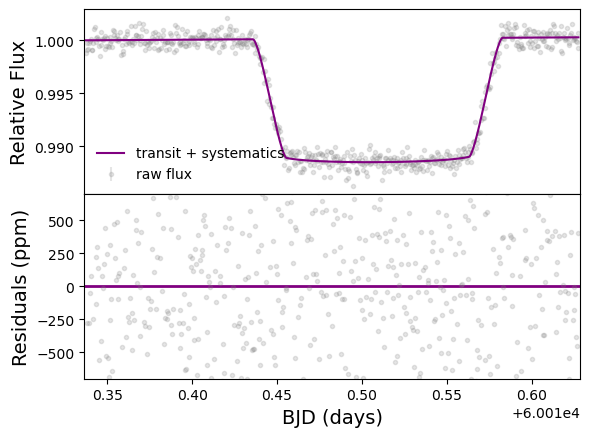

sys_fit values =  [ 5.80139399e+01 -1.05872085e-04 -5.75118068e+01  0.00000000e+00
  9.75028875e-04]
slope is s2:  0.0009750288751726951
1
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  1.4901161193847656e-08
slope is s2:  6.520833782847224e-06
slope is s2:  6.543574580041788e-06
slope is s2:  6.54925978812738e-06
slope is s2:  6.550681125296601e-06
slope is s2:  6.551036600180798e-06
slope is s2:  6.55112603130594e-06
slope is s2:  6.551150630333861e-06
slope is s2:  6.551165967309928e-06
slope is s2:  6.5512214793566286e-06
slope is s2:  6.5512214793566286e-06
slope is s2:  6.5512214793566286e-06
slope is s2:  6.5512214793566286e-06
slope is s2:  6.5512214793566286e-06
slope is s2:  6.5512214793566286e-06
slope is s2:  6.5512214793566286e-06
slope is s2:  6.566122640550476e-06
slope is s2:  3.669667223249855e-05
slope is s2:  3.669667223249855e-05
slope is s2:  3.669667223249855e-05
slope is 

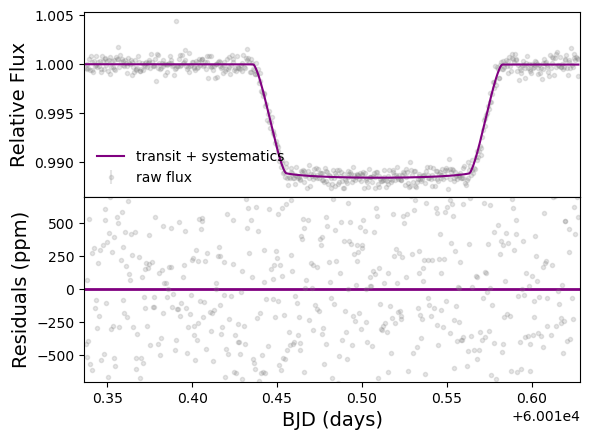

sys_fit values =  [ 4.34021320e+01 -2.62744496e-03  8.29075513e+00  2.78192502e-21
 -1.21491662e-04]
slope is s2:  -0.00012149166211477492
2
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  1.4901161193847656e-08
slope is s2:  0.00025065332515662064
slope is s2:  0.0002506904518788389
slope is s2:  0.000250699733236351
slope is s2:  0.00025070205228148085
slope is s2:  0.00025070262299731525
slope is s2:  0.0002507027488617821
slope is s2:  0.00025045947336244545
slope is s2:  7.769987696048633e-05
slope is s2:  7.769987696048633e-05
slope is s2:  7.769987696048633e-05
slope is s2:  7.769987696048633e-05
slope is s2:  7.769987696048633e-05
slope is s2:  7.769987696048633e-05
slope is s2:  7.769987696048633e-05
slope is s2:  7.771477812168018e-05
slope is s2:  0.00019976953699718883
slope is s2:  0.00019976953699718883
slope is s2:  0.00019976953699718883
slope is s2:  0.00019976953699718883
slope

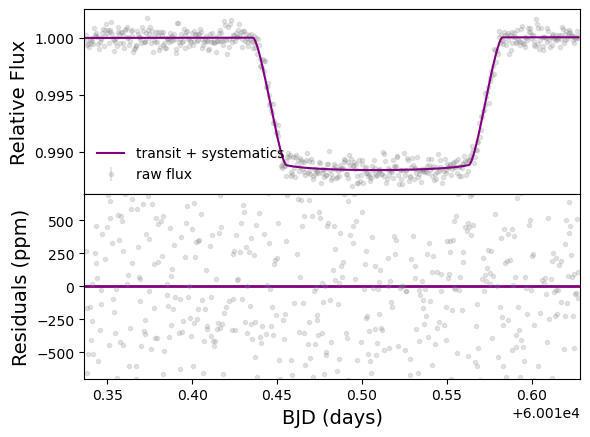

sys_fit values =  [ 1.56495587e+01  7.30612820e-04 -1.11939829e+01  0.00000000e+00
  2.03197770e-04]
slope is s2:  0.0002031977697125506
3
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  1.4901161193847656e-08
slope is s2:  0.0006101561646494928
slope is s2:  0.0006101740682315012
slope is s2:  0.0006101785432603056
slope is s2:  0.000610179657858928
slope is s2:  0.0006101799232890839
slope is s2:  0.0006101799048227279
slope is s2:  0.00026080605904304734
slope is s2:  0.00026080605904304734
slope is s2:  0.00026080605904304734
slope is s2:  0.00026080605904304734
slope is s2:  0.00026080605904304734
slope is s2:  0.00026080605904304734
slope is s2:  0.00026080605904304734
slope is s2:  0.0002608209602042412
slope is s2:  0.00025060144398475985
slope is s2:  0.00025060144398475985
slope is s2:  0.00025060144398475985
slope is s2:  0.00025060144398475985
slope is s2:  0.00025060144398475985
slo

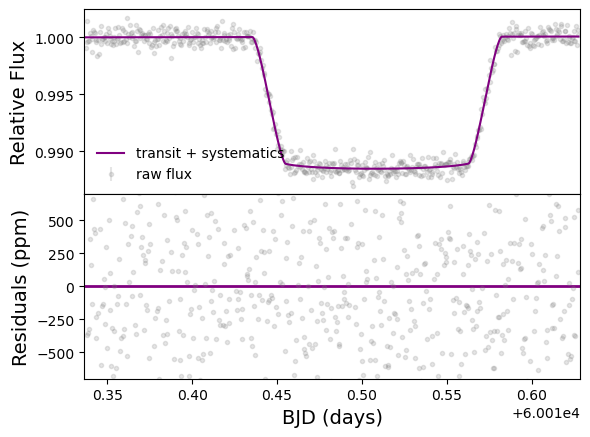

sys_fit values =  [-2.04107607e+02  7.02068705e-03 -1.39710089e+01  0.00000000e+00
  2.49473849e-04]
slope is s2:  0.00024947384933588244
4
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  1.4901161193847656e-08
slope is s2:  0.00039567523923435754
slope is s2:  0.0003956773379114992
slope is s2:  0.0003956778625361696
slope is s2:  0.0003956779934863233
slope is s2:  0.0003956779173975541
slope is s2:  0.00039567792447872197
slope is s2:  0.00026080515116203945
slope is s2:  0.00026080515116203945
slope is s2:  0.00026080515116203945
slope is s2:  0.00026080515116203945
slope is s2:  0.00026080515116203945
slope is s2:  0.00026080515116203945
slope is s2:  0.00026080515116203945
slope is s2:  0.0002608200523232333
slope is s2:  0.00022021067426363934
slope is s2:  0.00022021067426363934
slope is s2:  0.00022021067426363934
slope is s2:  0.00022021067426363934
slope is s2:  0.00022021067426363934

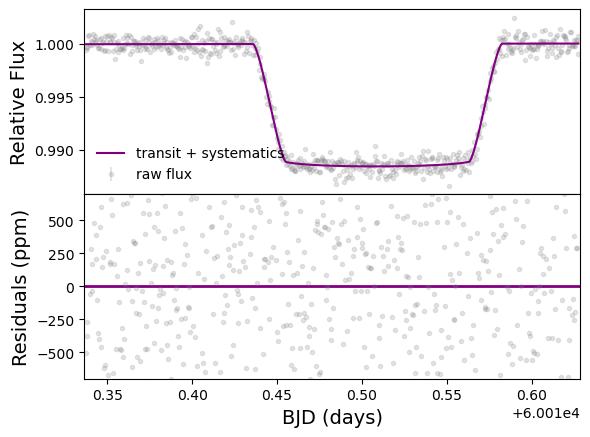

sys_fit values =  [ 3.02005702e+01 -3.43301140e-04 -1.22149649e+01  0.00000000e+00
  2.20210674e-04]
slope is s2:  0.00022021067426363934
5
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  1.4901161193847656e-08
slope is s2:  -0.0002725083043610061
slope is s2:  -0.0002724899655946502
slope is s2:  -0.00027248538007203086
slope is s2:  -0.0002724842303624964
slope is s2:  -0.00027248391485047696
slope is s2:  -0.000272483796054549
slope is s2:  -0.00022747683704044932
slope is s2:  -0.00022747683704044932
slope is s2:  -0.00022747683704044932
slope is s2:  -0.00022747683704044932
slope is s2:  -0.00022747683704044932
slope is s2:  -0.00022747683704044932
slope is s2:  -0.00022747683704044932
slope is s2:  -0.00022749173820164317
slope is s2:  -0.000469801948574616
slope is s2:  -0.000469801948574616
slope is s2:  -0.000469801948574616
slope is s2:  -0.000469801948574616
slope is s2:  -0.000469801

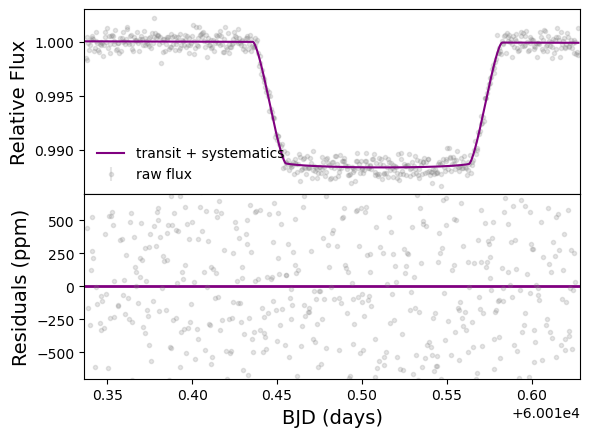

sys_fit values =  [ 8.50428953e+01 -3.88784234e-03  2.92475403e+01  6.90660959e-22
 -4.70710869e-04]
slope is s2:  -0.0004707108687263064
6
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  1.4901161193847656e-08
slope is s2:  -0.00019562313595722017
slope is s2:  -0.0001955856492972937
slope is s2:  -0.00019557627734992925
slope is s2:  -0.00019557393323124808
slope is s2:  -0.00019557334094831284
slope is s2:  -0.00019557317633085188
slope is s2:  -0.00019557262070480088
slope is s2:  -4.4372530074191526e-05
slope is s2:  -4.4372530074191526e-05
slope is s2:  -4.4372530074191526e-05
slope is s2:  -4.4372530074191526e-05
slope is s2:  -4.4372530074191526e-05
slope is s2:  -4.4372530074191526e-05
slope is s2:  -4.4372530074191526e-05
slope is s2:  -4.438743123538537e-05
slope is s2:  -0.00016644304771730928
slope is s2:  -0.00016644304771730928
slope is s2:  -0.00016644304771730928
slope is s2:  -

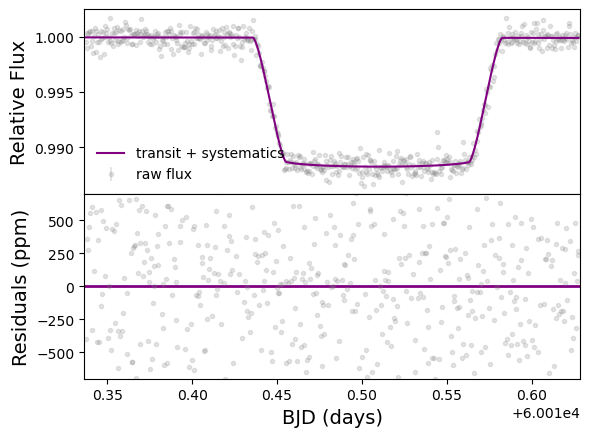

sys_fit values =  [ 1.00000000e+00 -5.10880996e-15  1.09882524e+01 -3.23876984e-32
 -1.66443048e-04]
slope is s2:  -0.00016644304771730928
7
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  1.4901161193847656e-08
slope is s2:  2.5279380942454664e-05
slope is s2:  2.5294581443213284e-05
slope is s2:  2.5298381552759068e-05
slope is s2:  2.5299331517570038e-05
slope is s2:  2.5299568758470045e-05
slope is s2:  2.5299627067428967e-05
slope is s2:  2.52996376200281e-05
slope is s2:  2.5299558126226645e-05
slope is s2:  2.529832737614018e-05
slope is s2:  2.529832737614018e-05
slope is s2:  2.529832737614018e-05
slope is s2:  2.529832737614018e-05
slope is s2:  2.529832737614018e-05
slope is s2:  2.529832737614018e-05
slope is s2:  2.529832737614018e-05
slope is s2:  2.531322853733403e-05
slope is s2:  5.5354990049765246e-05
slope is s2:  5.5354990049765246e-05
slope is s2:  5.5354990049765246e-05
slo

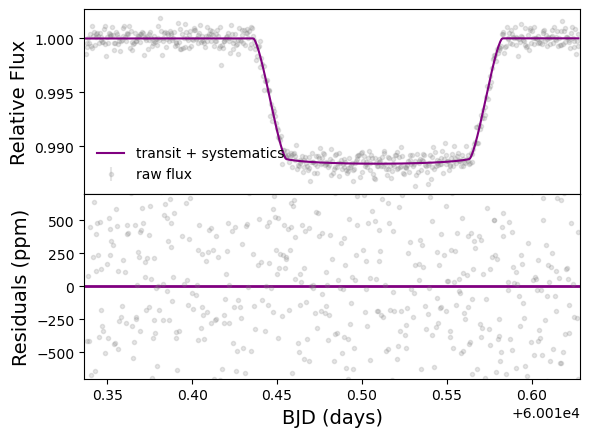

sys_fit values =  [-4.19757103e+01  3.95504506e-03 -1.99018470e+00 -5.55400271e-19
  4.98277569e-05]
slope is s2:  4.982775687638735e-05
8
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  1.4901161193847656e-08
slope is s2:  -4.274680517434035e-05
slope is s2:  -4.274025425408777e-05
slope is s2:  -4.273861647786503e-05
slope is s2:  -4.273820684916922e-05
slope is s2:  -4.27381037031453e-05
slope is s2:  -4.2738074243205316e-05
slope is s2:  -4.27380554238305e-05
slope is s2:  -4.273202980209385e-05
slope is s2:  -4.273202980209385e-05
slope is s2:  -4.273202980209385e-05
slope is s2:  -4.273202980209385e-05
slope is s2:  -4.273202980209385e-05
slope is s2:  -4.273202980209385e-05
slope is s2:  -4.273202980209385e-05
slope is s2:  -4.2746930963287695e-05
slope is s2:  -0.00016638372808419966
slope is s2:  -0.00016638372808419966
slope is s2:  -0.00016638372808419966
slope is s2:  -0.000166383728

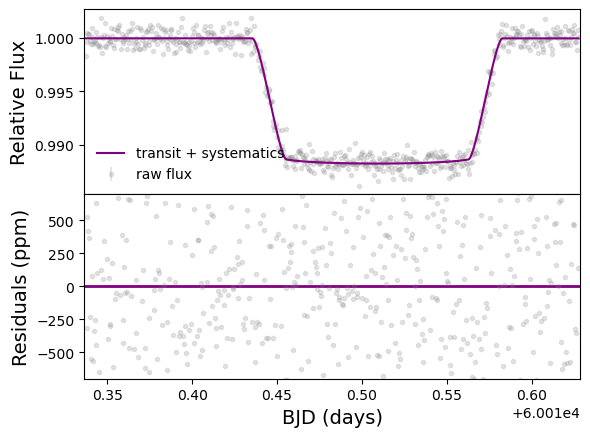

sys_fit values =  [ 7.77144763e+01 -2.34590267e-04  1.96997293e+00  8.82923539e-21
 -1.61638944e-05]
slope is s2:  -1.616389441416756e-05
9
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  1.4901161193847656e-08
slope is s2:  -0.0004868234838542242
slope is s2:  -0.0004868115112026115
slope is s2:  -0.00048680851755142157
slope is s2:  -0.0004868077669955009
slope is s2:  -0.0004868068442985971
slope is s2:  -0.00048680095651426603
slope is s2:  -0.00022747782631880916
slope is s2:  -0.00022747782631880916
slope is s2:  -0.00022747782631880916
slope is s2:  -0.00022747782631880916
slope is s2:  -0.00022747782631880916
slope is s2:  -0.00022747782631880916
slope is s2:  -0.00022747782631880916
slope is s2:  -0.000227492727480003
slope is s2:  -0.0001993261054198925
slope is s2:  -0.0001993261054198925
slope is s2:  -0.0001993261054198925
slope is s2:  -0.0001993261054198925
slope is s2:  -0.000199

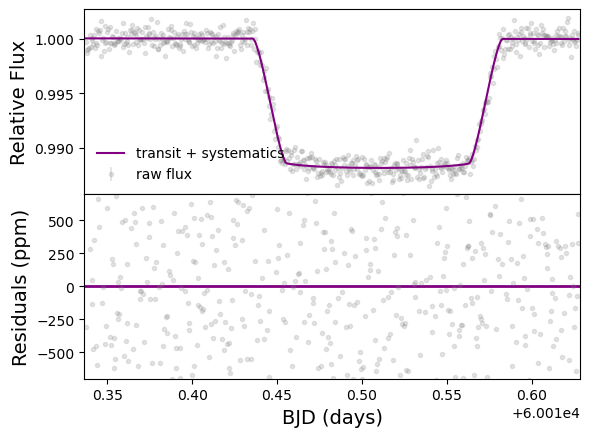

sys_fit values =  [-8.68572151e+01  1.39559145e-03  1.28740813e+01  0.00000000e+00
 -1.97866853e-04]
slope is s2:  -0.0001978668528793445
10
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  1.4901161193847656e-08
slope is s2:  -0.0005837269518895361
slope is s2:  -0.0005837134552508152
slope is s2:  -0.0005837100808341224
slope is s2:  -0.0005837092355247576
slope is s2:  -0.0005837090208871814
slope is s2:  -0.0005837089335417983
slope is s2:  -0.00022747655285281377
slope is s2:  -0.00022747655285281377
slope is s2:  -0.00022747655285281377
slope is s2:  -0.00022747655285281377
slope is s2:  -0.00022747655285281377
slope is s2:  -0.00022747655285281377
slope is s2:  -0.00022747655285281377
slope is s2:  -0.00022749145401400762
slope is s2:  -0.0004910030706246313
slope is s2:  -0.0004910030706246313
slope is s2:  -0.0004910030706246313
slope is s2:  -0.0004910030706246313
slope is s2:  -0.00049

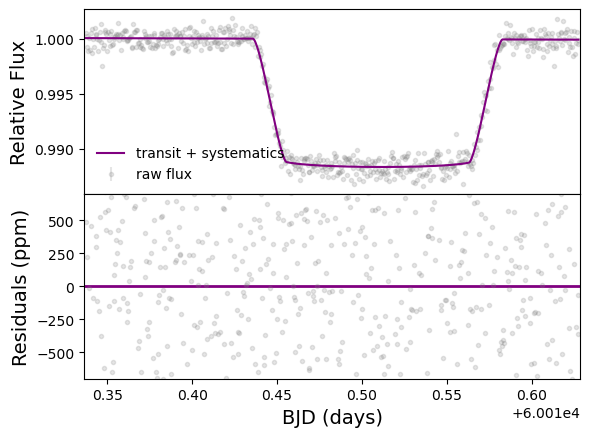

sys_fit values =  [ 2.56680780e+01  2.32764466e-03  3.04653481e+01  0.00000000e+00
 -4.91003071e-04]
slope is s2:  -0.0004910030706246313
11
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  1.4901161193847656e-08
slope is s2:  -2.0453219318475513e-05
slope is s2:  -2.0452139991726897e-05
slope is s2:  -2.045187015645959e-05
slope is s2:  -2.0451802683322063e-05
slope is s2:  -2.0451785757745624e-05
slope is s2:  -2.0451781276641964e-05
slope is s2:  -2.045177925026734e-05
slope is s2:  -2.0451773451748243e-05
slope is s2:  -2.0451773451748243e-05
slope is s2:  -2.0451773451748243e-05
slope is s2:  -2.0451773451748243e-05
slope is s2:  -2.0451773451748243e-05
slope is s2:  -2.0451773451748243e-05
slope is s2:  -2.0451773451748243e-05
slope is s2:  -2.046667461294209e-05
slope is s2:  -2.8836342686335075e-05
slope is s2:  -2.8836342686335075e-05
slope is s2:  -2.8836342686335075e-05
slope is s2:  -

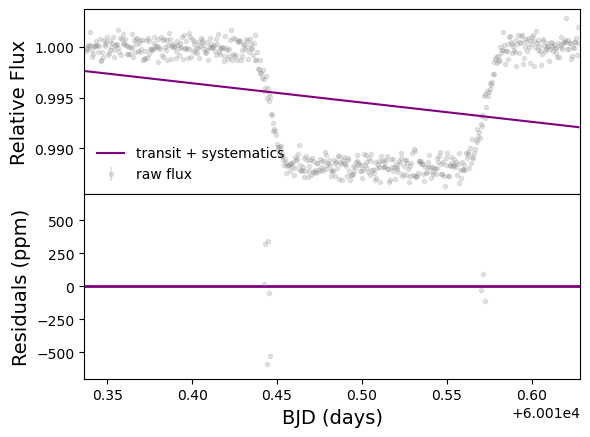

sys_fit values =  [ 1.00000000e+00  2.42737734e-15  5.71373356e+02 -9.04052619e-39
 -9.51293696e-03]
slope is s2:  -0.009512936959993008
12
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  1.4901161193847656e-08
slope is s2:  -0.0003191452131422648
slope is s2:  -0.00031915489201594547
slope is s2:  -0.00031915731143321627
slope is s2:  -0.0003191579150715834
slope is s2:  -0.0003191580188659248
slope is s2:  -0.00031915806068148257
slope is s2:  -0.0002274776790542595
slope is s2:  -0.0002274776790542595
slope is s2:  -0.0002274776790542595
slope is s2:  -0.0002274776790542595
slope is s2:  -0.0002274776790542595
slope is s2:  -0.0002274776790542595
slope is s2:  -0.0002274776790542595
slope is s2:  -0.00022749258021545336
slope is s2:  -0.00021462534003556158
slope is s2:  -0.00021462534003556158
slope is s2:  -0.00021462534003556158
slope is s2:  -0.00021462534003556158
slope is s2:  -0.000214

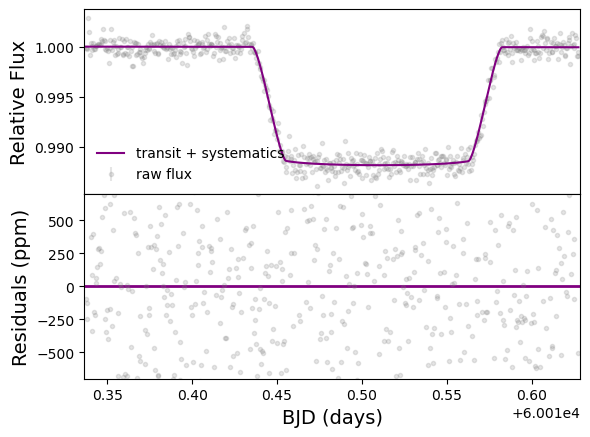

sys_fit values =  [ 8.88957326e+01  1.15213510e-03  1.37538998e+01 -2.98058634e-21
 -2.12527774e-04]
slope is s2:  -0.00021252777385857431
13
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  1.4901161193847656e-08
slope is s2:  -3.59267786945636e-05
slope is s2:  -3.5892545057789994e-05
slope is s2:  -3.5883986569979494e-05
slope is s2:  -3.58818466335515e-05
slope is s2:  -3.58813103912936e-05
slope is s2:  -3.588117100069433e-05
slope is s2:  -3.588111571393636e-05
slope is s2:  -3.588087940897642e-05
slope is s2:  -3.588087940897642e-05
slope is s2:  -3.588087940897642e-05
slope is s2:  -3.588087940897642e-05
slope is s2:  -3.588087940897642e-05
slope is s2:  -3.588087940897642e-05
slope is s2:  -3.588087940897642e-05
slope is s2:  -3.589578057017027e-05
slope is s2:  -0.00010537264218541694
slope is s2:  -0.00010537264218541694
slope is s2:  -0.00010537264218541694
slope is s2:  -0.0001053726

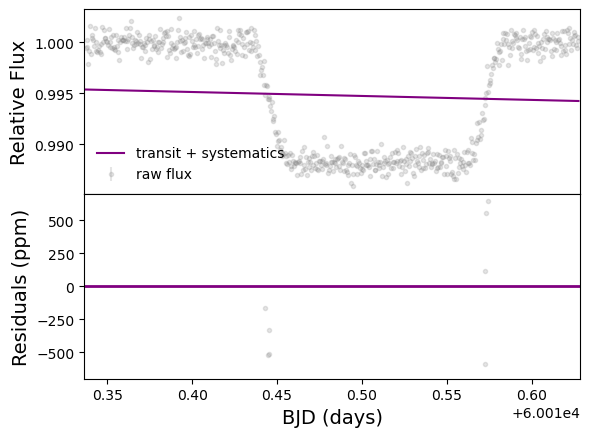

sys_fit values =  [ 1.00000000e+00  3.36671219e-14  1.16673704e+02  1.16772306e-34
 -1.93593354e-03]
slope is s2:  -0.0019359335427243146
14
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  1.4901161193847656e-08
slope is s2:  -0.0004570164389283384
slope is s2:  -0.0004569687934485209
slope is s2:  -0.0004569568811864258
slope is s2:  -0.00045695389939200555
slope is s2:  -0.0004569526637408314
slope is s2:  -0.00045695023246585274
slope is s2:  -0.00022747840711258
slope is s2:  -0.00022747840711258
slope is s2:  -0.00022747840711258
slope is s2:  -0.00022747840711258
slope is s2:  -0.00022747840711258
slope is s2:  -0.00022747840711258
slope is s2:  -0.00022747840711258
slope is s2:  -0.00022749330827377386
slope is s2:  -7.748599006153568e-05
slope is s2:  -7.748599006153568e-05
slope is s2:  -7.748599006153568e-05
slope is s2:  -7.748599006153568e-05
slope is s2:  -7.748599006153568e-05
slop

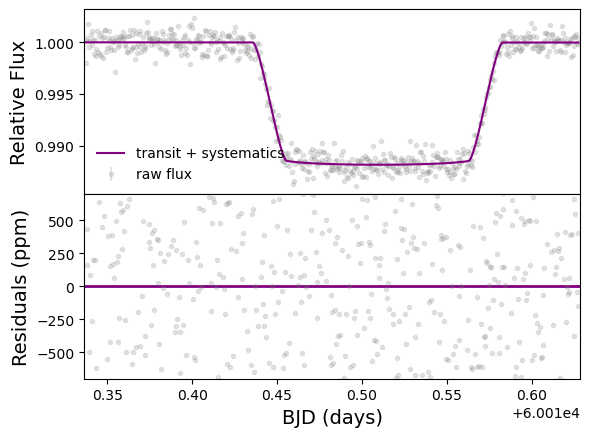

sys_fit values =  [-1.46926692e+02  3.03399813e-03  5.74111387e+00  0.00000000e+00
 -7.90049568e-05]
slope is s2:  -7.900495678359921e-05
15
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  1.4901161193847656e-08
slope is s2:  -0.0002795998592252489
slope is s2:  -0.0002795938578398507
slope is s2:  -0.00027959235699220983
slope is s2:  -0.0002795919797675214
slope is s2:  -0.0002795918597829774
slope is s2:  -0.0002795918150889383
slope is s2:  -0.00022747603994747176
slope is s2:  -0.00022747603994747176
slope is s2:  -0.00022747603994747176
slope is s2:  -0.00022747603994747176
slope is s2:  -0.00022747603994747176
slope is s2:  -0.00022747603994747176
slope is s2:  -0.00022747603994747176
slope is s2:  -0.0002274909411086656
slope is s2:  -0.00028729656465934633
slope is s2:  -0.00028729656465934633
slope is s2:  -0.00028729656465934633
slope is s2:  -0.00028729656465934633
slope is s2:  -0.0

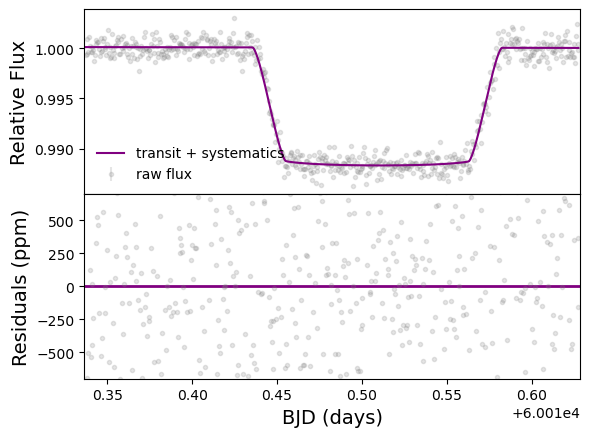

sys_fit values =  [ 8.86849694e+01 -8.74865457e-03  1.80488642e+01  0.00000000e+00
 -2.84096847e-04]
slope is s2:  -0.0002840968467612486
16
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  1.4901161193847656e-08
slope is s2:  -0.00049933851838791
slope is s2:  -0.000499333141348448
slope is s2:  -0.000499331795598826
slope is s2:  -0.0004993314529600904
slope is s2:  -0.0004993304785091028
slope is s2:  -0.0004993218257890458
slope is s2:  -0.00022747996133212797
slope is s2:  -0.00022747996133212797
slope is s2:  -0.00022747996133212797
slope is s2:  -0.00022747996133212797
slope is s2:  -0.00022747996133212797
slope is s2:  -0.00022747996133212797
slope is s2:  -0.00022747996133212797
slope is s2:  -0.0002274948624933218
slope is s2:  -0.00014447536581058216
slope is s2:  -0.00014447536581058216
slope is s2:  -0.00014447536581058216
slope is s2:  -0.00014447536581058216
slope is s2:  -0.000144

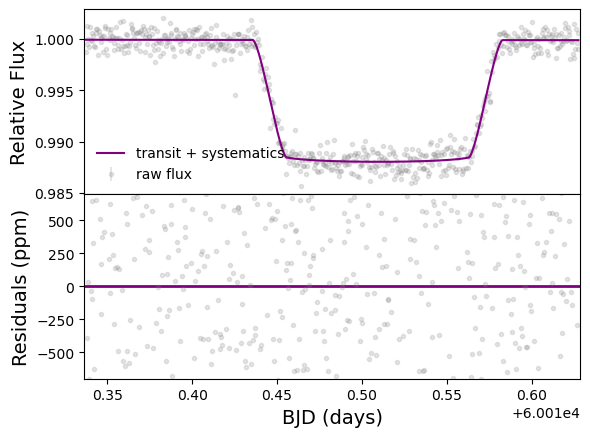

sys_fit values =  [ 8.84795494e+01  5.85295207e-03  9.68738501e+00  0.00000000e+00
 -1.44766241e-04]
slope is s2:  -0.00014476624116295563
17
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  1.4901161193847656e-08
slope is s2:  -0.0002687888532956616
slope is s2:  -0.00026879171650016947
slope is s2:  -0.00026879243227613677
slope is s2:  -0.0002687926111142431
slope is s2:  -0.00026879264186990153
slope is s2:  -0.00026879266338159966
slope is s2:  -0.00022747879983839493
slope is s2:  -0.00022747879983839493
slope is s2:  -0.00022747879983839493
slope is s2:  -0.00022747879983839493
slope is s2:  -0.00022747879983839493
slope is s2:  -0.00022747879983839493
slope is s2:  -0.00022747879983839493
slope is s2:  -0.00022749370099958878
slope is s2:  0.00026080436829062223
slope is s2:  0.00026080436829062223
slope is s2:  0.00026080436829062223
slope is s2:  0.00026080436829062223
slope is s2:  0.0

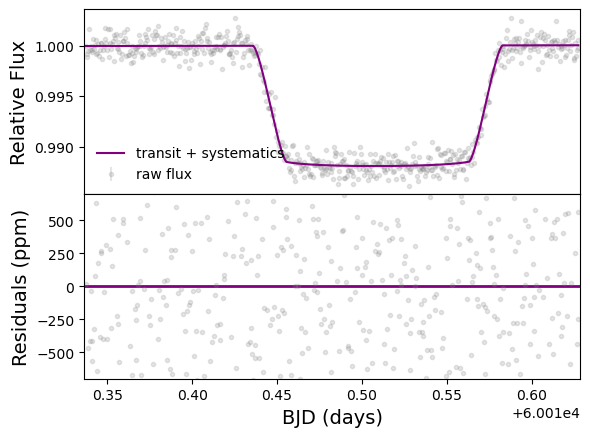

sys_fit values =  [ 1.00000000e+00  2.17192226e-14 -1.46510032e+01  0.00000000e+00
  2.60804368e-04]
slope is s2:  0.00026080436829062223
18
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  1.4901161193847656e-08
slope is s2:  -0.00025566634543734804
slope is s2:  -0.00025564941594138533
slope is s2:  -0.0002556451833012041
slope is s2:  -0.00025564412407333426
slope is s2:  -0.0002556438453292397
slope is s2:  -0.0002556437690353183
slope is s2:  -0.0002274804805487658
slope is s2:  -0.0002274804805487658
slope is s2:  -0.0002274804805487658
slope is s2:  -0.0002274804805487658
slope is s2:  -0.0002274804805487658
slope is s2:  -0.0002274804805487658
slope is s2:  -0.0002274804805487658
slope is s2:  -0.00022749538170995965
slope is s2:  0.0002608028349361637
slope is s2:  0.0002608028349361637
slope is s2:  0.0002608028349361637
slope is s2:  0.0002608028349361637
slope is s2:  0.00026080283493

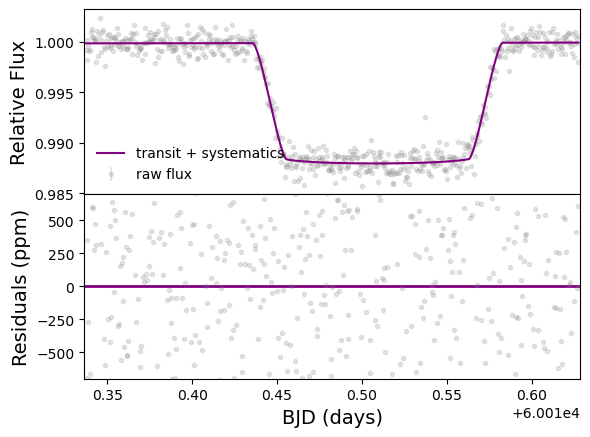

sys_fit values =  [ 1.00000000e+00 -1.03934433e-14 -1.46510032e+01 -3.92194831e-38
  2.60802835e-04]
slope is s2:  0.0002608028349361637
19
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  1.4901161193847656e-08
slope is s2:  -0.00024978015525540213
slope is s2:  -0.00024976532449251315
slope is s2:  -0.0002497616167009996
slope is s2:  -0.0002497606893469258
slope is s2:  -0.00024976044757783826
slope is s2:  -0.0002497603902400046
slope is s2:  -0.00022747881939185136
slope is s2:  -0.00022747881939185136
slope is s2:  -0.00022747881939185136
slope is s2:  -0.00022747881939185136
slope is s2:  -0.00022747881939185136
slope is s2:  -0.00022747881939185136
slope is s2:  -0.00022747881939185136
slope is s2:  -0.0002274937205530452
slope is s2:  -5.087310366240196e-06
slope is s2:  -5.087310366240196e-06
slope is s2:  -5.087310366240196e-06
slope is s2:  -5.087310366240196e-06
slope is s2:  -5.0873

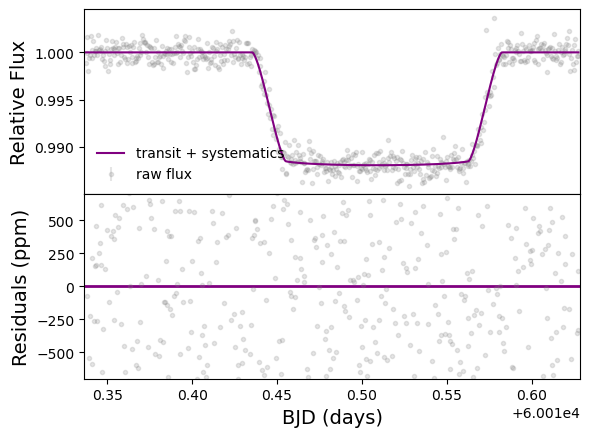

sys_fit values =  [-8.36870135e+01  3.84424934e-03  6.75680411e-01 -1.41708431e-19
  5.40426977e-06]
slope is s2:  5.404269766792097e-06
20
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  1.4901161193847656e-08
slope is s2:  -0.000663121519257299
slope is s2:  -0.0006631382385415902
slope is s2:  -0.0006631424173650061
slope is s2:  -0.0006631434564154265
slope is s2:  -0.000663143701981769
slope is s2:  -0.0006631431131856834
slope is s2:  -0.00022747683821783125
slope is s2:  -0.00022747683821783125
slope is s2:  -0.00022747683821783125
slope is s2:  -0.00022747683821783125
slope is s2:  -0.00022747683821783125
slope is s2:  -0.00022747683821783125
slope is s2:  -0.00022747683821783125
slope is s2:  -0.0002274917393790251
slope is s2:  -0.00028828560796099665
slope is s2:  -0.00028828560796099665
slope is s2:  -0.00028828560796099665
slope is s2:  -0.00028828560796099665
slope is s2:  -0.00028

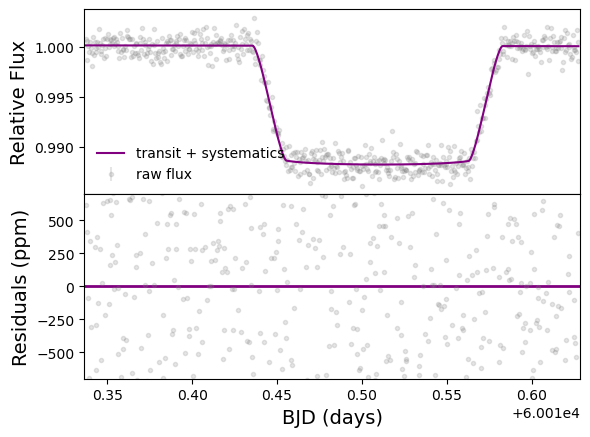

sys_fit values =  [-8.66776813e+01  8.58654903e-03  1.81430282e+01  0.00000000e+00
 -2.85665631e-04]
slope is s2:  -0.00028566563143087097
21
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  1.4901161193847656e-08
slope is s2:  0.00013837437700452943
slope is s2:  0.00013840122017011816
slope is s2:  0.00013840793071157105
slope is s2:  0.0001384096073470929
slope is s2:  0.00013841002246163525
slope is s2:  0.00013840994070965002
slope is s2:  0.0001384088780720467
slope is s2:  7.769764234525202e-05
slope is s2:  7.769764234525202e-05
slope is s2:  7.769764234525202e-05
slope is s2:  7.769764234525202e-05
slope is s2:  7.769764234525202e-05
slope is s2:  7.769764234525202e-05
slope is s2:  7.769764234525202e-05
slope is s2:  7.771254350644587e-05
slope is s2:  0.00019976955125699438
slope is s2:  0.00019976955125699438
slope is s2:  0.00019976955125699438
slope is s2:  0.00019976955125699438
sl

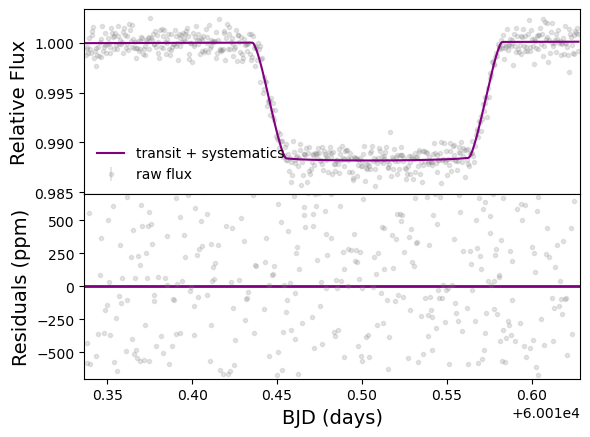

sys_fit values =  [-2.81823771e+01 -9.64466029e-04 -2.82843349e+01 -8.47772644e-23
  4.87987355e-04]
slope is s2:  0.0004879873549452241
22
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  1.4901161193847656e-08
slope is s2:  0.00021325269716357745
slope is s2:  0.00021324637610536736
slope is s2:  0.00021324479581506903
slope is s2:  0.000213244400639245
slope is s2:  0.00021324430028430393
slope is s2:  0.00021324427493526
slope is s2:  0.00021323041065705975
slope is s2:  7.770030083967802e-05
slope is s2:  7.770030083967802e-05
slope is s2:  7.770030083967802e-05
slope is s2:  7.770030083967802e-05
slope is s2:  7.770030083967802e-05
slope is s2:  7.770030083967802e-05
slope is s2:  7.770030083967802e-05
slope is s2:  7.771520200087186e-05
slope is s2:  0.0001997715752632601
slope is s2:  0.0001997715752632601
slope is s2:  0.0001997715752632601
slope is s2:  0.0001997715752632601
slope is s2

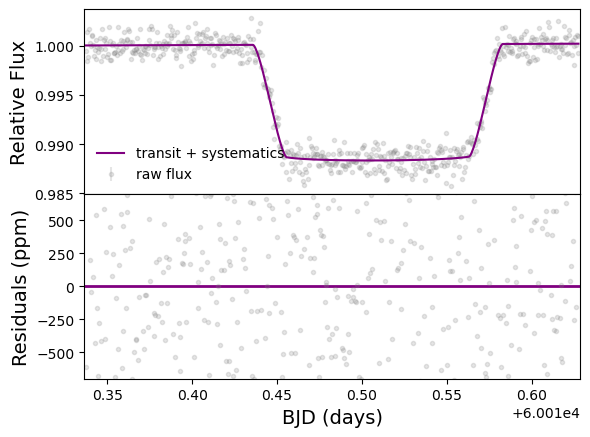

sys_fit values =  [-2.63529448e+01 -8.55959746e-04 -3.61475377e+01  0.00000000e+00
  6.19019899e-04]
slope is s2:  0.0006190198989999864
23
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  1.4901161193847656e-08
slope is s2:  -0.00026656585884322323
slope is s2:  -0.00026654831975785303
slope is s2:  -0.00026654393483239064
slope is s2:  -0.0002665428379800706
slope is s2:  -0.00026654254851057576
slope is s2:  -0.0002665424804200417
slope is s2:  -0.00022747849233371723
slope is s2:  -0.00022747849233371723
slope is s2:  -0.00022747849233371723
slope is s2:  -0.00022747849233371723
slope is s2:  -0.00022747849233371723
slope is s2:  -0.00022747849233371723
slope is s2:  -0.00022747849233371723
slope is s2:  -0.00022749339349491108
slope is s2:  0.00011071785628517664
slope is s2:  0.00011071785628517664
slope is s2:  0.00011071785628517664
slope is s2:  0.00011071785628517664
slope is s2:  0.000

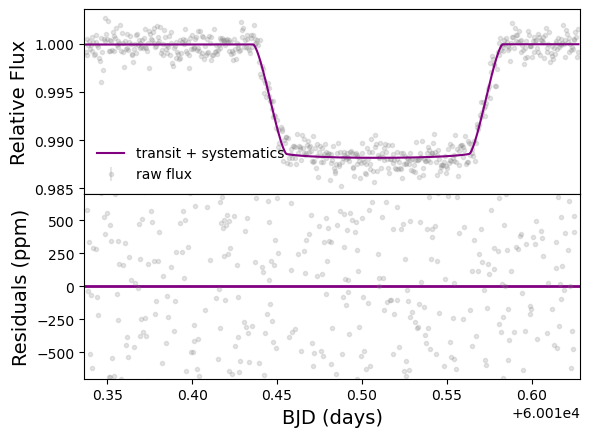

sys_fit values =  [ 2.21354933e+01 -6.67291038e-04 -5.64427956e+00  0.00000000e+00
  1.10717856e-04]
slope is s2:  0.00011071785628517664
24
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  1.4901161193847656e-08
slope is s2:  -0.00025839451570709325
slope is s2:  -0.0002583776760308472
slope is s2:  -0.00025837346538030656
slope is s2:  -0.00025837240978792396
slope is s2:  -0.0002583721237659886
slope is s2:  -0.0002583720148840554
slope is s2:  -0.00022747638429114077
slope is s2:  -0.00022747638429114077
slope is s2:  -0.00022747638429114077
slope is s2:  -0.00022747638429114077
slope is s2:  -0.00022747638429114077
slope is s2:  -0.00022747638429114077
slope is s2:  -0.00022747638429114077
slope is s2:  -0.00022749128545233462
slope is s2:  0.00018729307018686259
slope is s2:  0.00018729307018686259
slope is s2:  0.00018729307018686259
slope is s2:  0.00018729307018686259
slope is s2:  0.000

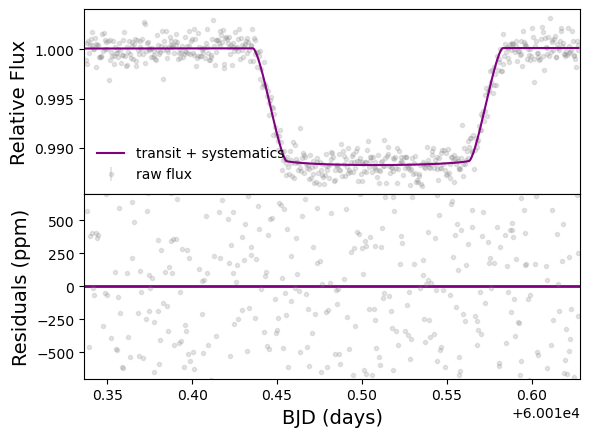

sys_fit values =  [-1.44619934e+01  3.28068299e-03 -1.02394433e+01  3.70967229e-39
  1.87293070e-04]
slope is s2:  0.00018729307018686259
25
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  1.4901161193847656e-08
slope is s2:  -0.001021018555465738
slope is s2:  -0.0010210116939182803
slope is s2:  -0.001021009975424262
slope is s2:  -0.0010210095036089855
slope is s2:  -0.0010210093696399057
slope is s2:  -0.0009599024427953289
slope is s2:  -0.0009599024427953289
slope is s2:  -0.0009599024427953289
slope is s2:  -0.0009599024427953289
slope is s2:  -0.0009599024427953289
slope is s2:  -0.0009599024427953289
slope is s2:  -0.0009599024427953289
slope is s2:  -0.0009599173439565228
slope is s2:  -0.0005186541607780689
slope is s2:  -0.0005186541607780689
slope is s2:  -0.0005186541607780689
slope is s2:  -0.0005186541607780689
slope is s2:  -0.0005186541607780689
slope is s2:  -0.000518654160778

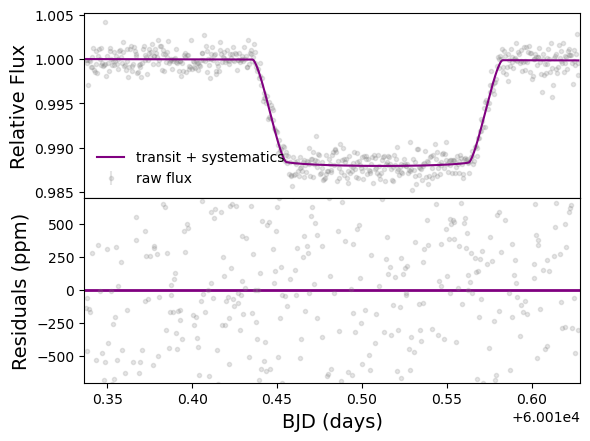

sys_fit values =  [ 3.49593725e+02 -2.25653691e-02  3.19153769e+01 -1.13905874e-21
 -5.15167465e-04]
slope is s2:  -0.0005151674654454708
26
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  1.4901161193847656e-08
slope is s2:  -0.0006783367026478977
slope is s2:  -0.0006783294218088931
slope is s2:  -0.0006783276001542355
slope is s2:  -0.0006783271371192646
slope is s2:  -0.0006783270000566383
slope is s2:  -0.0006783257257923345
slope is s2:  -0.0002274774312694139
slope is s2:  -0.0002274774312694139
slope is s2:  -0.0002274774312694139
slope is s2:  -0.0002274774312694139
slope is s2:  -0.0002274774312694139
slope is s2:  -0.0002274774312694139
slope is s2:  -0.0002274774312694139
slope is s2:  -0.00022749233243060774
slope is s2:  -0.0005876879463389899
slope is s2:  -0.0005876879463389899
slope is s2:  -0.0005876879463389899
slope is s2:  -0.0005876879463389899
slope is s2:  -0.000587687946

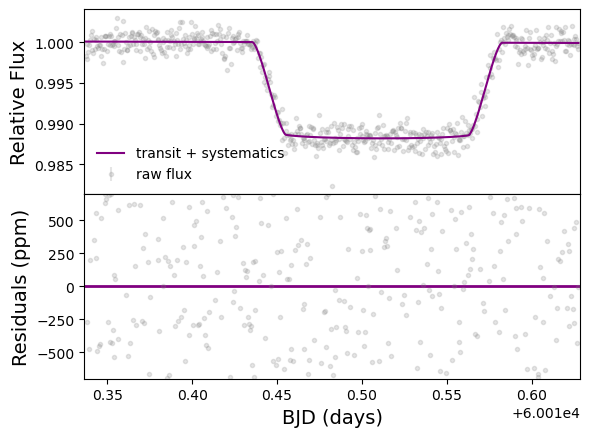

sys_fit values =  [ 1.96594145e+02 -1.49360457e-03  3.63862951e+01  0.00000000e+00
 -5.89668201e-04]
slope is s2:  -0.0005896682014007589
27
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  1.4901161193847656e-08
slope is s2:  -0.0004655614722688348
slope is s2:  -0.0004655551057939759
slope is s2:  -0.0004655535124834166
slope is s2:  -0.00046555310723954494
slope is s2:  -0.00046555244084520733
slope is s2:  -0.0004655493598982912
slope is s2:  -0.00022747684250895252
slope is s2:  -0.00022747684250895252
slope is s2:  -0.00022747684250895252
slope is s2:  -0.00022747684250895252
slope is s2:  -0.00022747684250895252
slope is s2:  -0.00022747684250895252
slope is s2:  -0.00022747684250895252
slope is s2:  -0.00022749174367014637
slope is s2:  -0.00037557777739011895
slope is s2:  -0.00037557777739011895
slope is s2:  -0.00037557777739011895
slope is s2:  -0.00037557777739011895
slope is s2:  -0

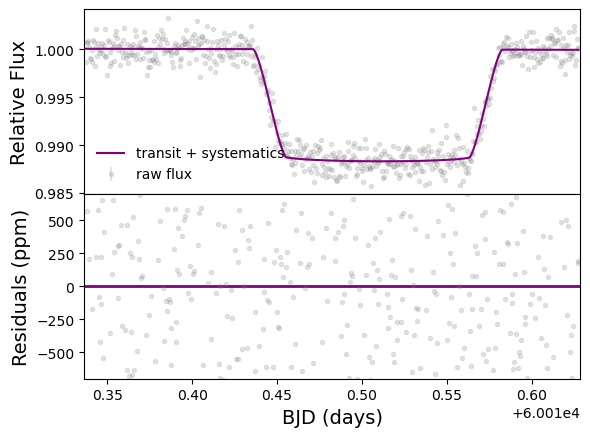

sys_fit values =  [-2.69216418e+01  3.14622440e-04  2.35386069e+01  0.00000000e+00
 -3.75577777e-04]
slope is s2:  -0.00037557777739011895
28
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  1.4901161193847656e-08
slope is s2:  0.0004631832989198897
slope is s2:  0.00046313484415038195
slope is s2:  0.00046312272997631307
slope is s2:  0.0004631197005510099
slope is s2:  0.00046311858347301295
slope is s2:  0.0004631175490494667
slope is s2:  0.0002608062518138018
slope is s2:  0.0002608062518138018
slope is s2:  0.0002608062518138018
slope is s2:  0.0002608062518138018
slope is s2:  0.0002608062518138018
slope is s2:  0.0002608062518138018
slope is s2:  0.0002608062518138018
slope is s2:  0.00026082115297499563
slope is s2:  0.00029292897472180427
slope is s2:  0.00029292897472180427
slope is s2:  0.00029292897472180427
slope is s2:  0.00029292897472180427
slope is s2:  0.00029292897472180427
sl

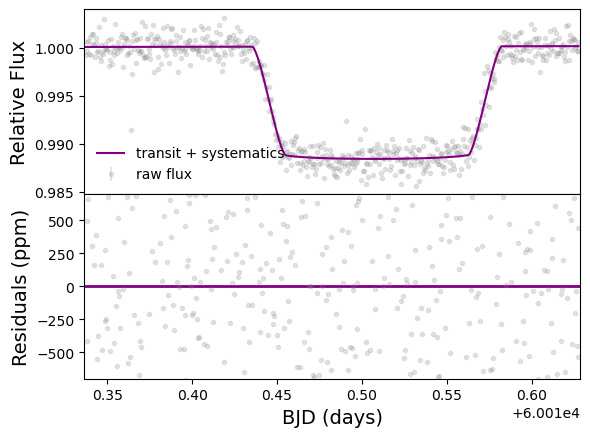

sys_fit values =  [ 8.88425783e+01 -1.47915657e-02 -1.65047899e+01  1.21690257e-21
  2.91697310e-04]
slope is s2:  0.0002916973103407083
29
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  1.4901161193847656e-08
slope is s2:  -0.00010668428477108333
slope is s2:  -0.00010668951143742288
slope is s2:  -0.00010669081784618087
slope is s2:  -0.00010669114341700536
slope is s2:  -0.00010669122064639143
slope is s2:  -0.00010669108209267841
slope is s2:  -0.00010669005808738097
slope is s2:  -4.437208815308481e-05
slope is s2:  -4.437208815308481e-05
slope is s2:  -4.437208815308481e-05
slope is s2:  -4.437208815308481e-05
slope is s2:  -4.437208815308481e-05
slope is s2:  -4.437208815308481e-05
slope is s2:  -4.437208815308481e-05
slope is s2:  -4.4386989314278656e-05
slope is s2:  2.9216872536542488e-05
slope is s2:  2.9216872536542488e-05
slope is s2:  2.9216872536542488e-05
slope is s2:  2.9216872

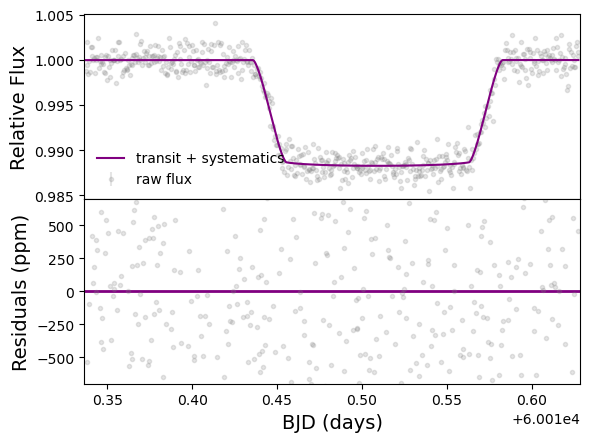

sys_fit values =  [-4.84474180e+00 -5.46199793e-05 -7.53352344e-01  8.14291010e-38
  2.92168725e-05]
slope is s2:  2.9216872536542488e-05
30
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  1.4901161193847656e-08
slope is s2:  -0.0006886341986920272
slope is s2:  -0.000688632609627626
slope is s2:  -0.0006886322121318307
slope is s2:  -0.0006886321099127621
slope is s2:  -0.0006886320830372979
slope is s2:  -0.0006886303253024748
slope is s2:  -0.0002274782646144425
slope is s2:  -0.0002274782646144425
slope is s2:  -0.0002274782646144425
slope is s2:  -0.0002274782646144425
slope is s2:  -0.0002274782646144425
slope is s2:  -0.0002274782646144425
slope is s2:  -0.0002274782646144425
slope is s2:  -0.00022749316577563635
slope is s2:  -0.00031032822303292976
slope is s2:  -0.00031032822303292976
slope is s2:  -0.00031032822303292976
slope is s2:  -0.00031032822303292976
slope is s2:  -0.000310328

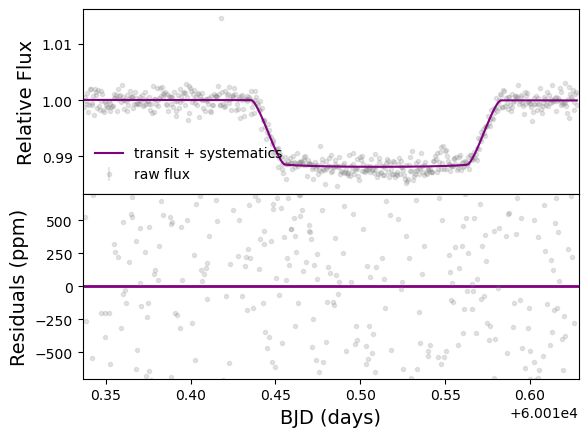

sys_fit values =  [ 3.07268823e+01 -7.15001082e-03  1.96747234e+01 -8.60288349e-20
 -3.11191040e-04]
slope is s2:  -0.000311191039845045
31
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  0.0
slope is s2:  1.4901161193847656e-08
slope is s2:  -0.0008201211581275633
slope is s2:  -0.0008200844108156427
slope is s2:  -0.0008200752230617868
slope is s2:  -0.0008200729153684727
slope is s2:  -0.0008200723321438369
slope is s2:  -0.0008200715061662098
slope is s2:  -0.00022747889226948617
slope is s2:  -0.00022747889226948617
slope is s2:  -0.00022747889226948617
slope is s2:  -0.00022747889226948617
slope is s2:  -0.00022747889226948617
slope is s2:  -0.00022747889226948617
slope is s2:  -0.00022747889226948617
slope is s2:  -0.00022749379343068002
slope is s2:  -0.000576643965368788
slope is s2:  -0.000576643965368788
slope is s2:  -0.000576643965368788
slope is s2:  -0.000576643965368788
slope is s2:  -0.0005766439

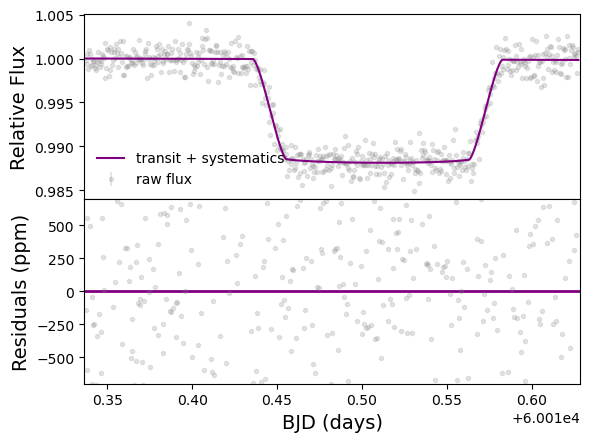

sys_fit values =  [ 2.14830211e+01 -3.14911343e-04  3.56046050e+01  0.00000000e+00
 -5.76643965e-04]
slope is s2:  -0.000576643965368788


,bin_start,bin_end,RpRs,RpRs_err,slope,slope_err
0,3.819918,3.859373,0.107098,0.000278,0.000975,0.000350
1,3.859373,3.898828,0.106669,0.000262,-0.000121,0.000329
2,3.898828,3.938284,0.106852,0.000261,0.000203,0.000327
3,3.938284,3.977739,0.106704,0.000239,0.000249,0.000300
4,3.977739,4.017194,0.106718,0.000268,0.000220,0.000336
5,4.017194,4.056649,0.106730,0.000270,-0.000471,0.000337
6,4.056649,4.096105,0.107214,0.000274,-0.000166,0.000346
7,4.096105,4.135560,0.106881,0.000280,0.000050,0.000352
8,4.135560,4.175015,0.107439,0.000293,-0.000016,0.000369
9,4.175015,4.214470,0.107807,0.000298,-0.000198,0.000378


In [781]:
wl1 = 3.819918
wl2 = 5.082485

fit_nrs2(spec_file, wl1, wl2)